In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import os
import csv
import base64
import requests
import json
from utils import *

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [4]:
def get_area(gray_image, mask, threshold):
    '''
    Go through the image and get the area of all the pixels above the threshold
    '''
    total = 0
    count = 0
    new_mask = np.zeros(mask.shape)
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x]:
                pixel_value = gray_image[y,x][0]
                if pixel_value >= threshold: 
                    total += 1
                    new_mask[y,x] = 1
                count += 1

    return new_mask

def get_gradient(gray_image, masks, scores):
    '''
    Go layer by layer during the image
    Plot the 
    '''
    main_mask, _ = get_main_mask(masks, scores)

    gradient = []
    for y in range(main_mask.shape[0]):
        total = 0
        count = 0
        for x in range(main_mask.shape[1]):
            if main_mask[y, x]:
                total += gray_image[y,x][0]
                count += 1
        if count != 0:
            gradient.append(total // count)
        else:
            gradient.append(0)

    return gradient

def get_main_mask(masks, scores):
    sorted_masks = sorted(zip(masks, scores), key=lambda x: x[1], reverse=True)
    main_mask = sorted_masks[0][0]
    main_mask_score = sorted_masks[0][1]
    return main_mask, main_mask_score

In [5]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [6]:
def get_bounding_box(main_mask, new_image):

    boundingBox = {
        "topLeft": None,
        "bottomRight": [0,0],
    }

    topLeft = False

    for i in range(len(new_image)):
        for j in range(len(new_image[0])):
            if not main_mask[i][j]:
                new_image[i][j] = [0, 0, 0]
            else:
                if not topLeft:
                    boundingBox["topLeft"] = [j, i]
                    topLeft = True
                boundingBox["bottomRight"] = [max(boundingBox["bottomRight"][0], j), max(boundingBox["bottomRight"][1], i)]
    
    return new_image, boundingBox

In [7]:
def get_middle_coordinate(top_left_x, top_left_y, wBox, hbox):
    '''
    Get the center of the box
    '''
    return top_left_x + wBox // 2, top_left_y + hbox // 2


In [8]:
def convertPoint(point, boundingBox, width, height, x_axis, y_axis):

    b_width = boundingBox["bottomRight"][0] - boundingBox["topLeft"][0]
    b_height = boundingBox["bottomRight"][1] - boundingBox["topLeft"][1]
    point_x, point_y = point

    x = (point_x - boundingBox["topLeft"][0]) / b_width
    y = (boundingBox["bottomRight"][1] - point_y) / b_height

    x *= (x_axis[1] - x_axis[0])
    x += x_axis[0]

    y *= (y_axis[1] - y_axis[0])
    y += y_axis[0]
    
    return [x, y]


In [9]:
convertPoint((62, 212), {'topLeft': [62, 37], 'bottomRight': [405, 314]}, 418, 352, [3, 6],[-1, 2])

[3.0, 0.10469314079422398]

In [10]:
def get_filtered_answer(mask, x0, y0, wBox, hBox, max_x, max_y):
    for x in range(x0, x0 + wBox + 1):
        for y in range(y0, y0 + hBox + 1):
            if x <= max_x and y <= max_y and mask[x, y] == 1: 
                return True
    return False

In [11]:
import math
colors = {
    "black": (0, 0, 0),
    "grey": (128, 128, 128),
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "purple": (128, 0, 128),
    "green": (0, 255, 0),
    "yellow": (255, 255, 0),
    "blue": (0, 0, 255),
    "pink": (255,20,147),
    "orange": (255, 165, 0),
}

def distance(a,b):
    dx = a[0]-b[0]
    dy = a[1]-b[1]
    dz = a[2]-b[2]
    dist = math.sqrt(dx*dx+dy*dy+dz*dz)
    return dist

def get_nearest_color(input_pixel):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in colors:
        rgb = colors[name]
        d = distance((p1, p2, p3), rgb)
        if d < mn:
            mn = d
            color = name
    return color

def get_nearest_color_within_colors(input_pixel, graph_colors):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in graph_colors + ["white", "black"]:
        if name in colors:
            rgb = colors[name]
            d = distance((p1, p2, p3), rgb)
            if d < mn:
                mn = d
                color = name
    return color

In [12]:
def get_points(boundingBox, image_name, color, graph_colors, wBox, hBox, x_axis, y_axis, onlyColorsInImage):

    graph = []
    image = Image.open(image_name)
    image = image.convert('RGB')

    width, height = image.size
    mask = np.zeros((width, height))

    print(mask.shape)

    for y in range(0, height):
        for x in range(0, width):

            pixel_value = image.getpixel((x, y))

            new_color = get_nearest_color_within_colors(pixel_value, graph_colors) if onlyColorsInImage else get_nearest_color(pixel_value) 

            if new_color == color:
                mask[x, y] = 1

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

PROMPT TO GPT:

Based on the plot:

1. What is the title of the x-axis?
2. What is the range of the x-axis?
3. What is the title of the first / primary y-axis?
4. What is the range of the first / primary y-axis?
5. What are the different types?

Can you provide the answers to the aforementioned questions in the following format:

answers = {
    "x-axis": {
        "title": [INSERT TITLE HERE IN STRING FORMAT],
        "range":  INSERT RANGE IN NUMERICAL FORM [start, end],
    },
    "y-axis": {
        "title": [INSERT TITLE HERE IN STRING FORMAT],
        "range":  INSERT RANGE IN NUMERICAL FORM [start, end],
    },
    "types": 
        [INSERT THE TYPES IN LIST OF LISTS OF LENGTH = 2 WHERE EACH LIST LOOKS LIKE [TYPE NAME, MARKER COLOR from the required list of colors: 'black', 'grey', 'white', 'red', 'purple', 'green', 'yellow', 'blue', 'pink', 'orange']]
}

In [13]:
def getColoredGrid(boundingBox, image_name, color, save_name, wBox, hBox):
    new_image = Image.open(image_name)

    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(new_image)

    count = 0
    
    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):

            if count < len(color) and color[count]["topLeft"][0] == x0 and color[count]["topLeft"][1] == y0:
                print("here")
                plt.gca().add_patch(plt.Rectangle((x0, y0), wBox, hBox, edgecolor='orange', facecolor=(1, 0.5, 0, 0.5), lw=2))
                count+=1
            
            else:
                plt.gca().add_patch(plt.Rectangle((x0, y0), wBox, hBox, edgecolor='orange', facecolor=(0,0,0,0), lw=2))

    plt.savefig(save_name)

In [14]:
def create_directory(directory):
    exists = os.path.exists(directory)
    if not exists:
        os.makedirs(directory)

In [15]:
def x_y(coordinates, title, x_axis_title, y_axis_title, filename, c, x_range, y_range, axis_labels, csv_filename, normalize = False):

    data_for_csv = []
    plt.figure(figsize=(10,6))

    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        print(x)
        print(y)
        
        color_normalized = c[index]

        if normalize and len(x) > 0:
            Q1_x, Q3_x = np.percentile(x, [25, 75])
            IQR_x = Q3_x - Q1_x
            Q1_y, Q3_y = np.percentile(y, [25, 75])
            IQR_y = Q3_y - Q1_y

            outliers_x = []
            outliers_y = []
            real_x = []
            real_y = []
            for i, x_i in enumerate(x):
                if x_i < Q1_x - 1.5 * IQR_x or x_i > Q3_x + 1.5 * IQR_x or y[i] < Q1_y - 1.5 * IQR_y or y[i] > Q3_y + 1.5 * IQR_y:
                    outliers_x.append(x_i)
                    outliers_y.append(y[i])
                else:
                    real_x.append(x_i)
                    real_y.append(y[i])
        
            plt.scatter(real_x, real_y, label=axis_labels[index], color=color_normalized)
            plt.scatter(outliers_x, outliers_y, label=axis_labels[index] + ' Outliers', color=color_normalized, marker='*')
            
        else:
            plt.scatter(x, y, label=axis_labels[index], color=color_normalized)

        for i, x_i in enumerate(x):
            data_for_csv.append([x_i, y[i], axis_labels[index]])

    

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)

    # Write to CSV
    with open(csv_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([x_axis_title, y_axis_title, "Type"])  # Header
        writer.writerows(data_for_csv)

In [16]:
def do_analysis(image_number):
    image_name = '../plot_images/'+str(image_number)+'.png'
    image = cv2.imread(image_name)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    main_mask, main_mask_score = get_main_mask(masks, scores)

    n_image = image.copy()
    new_image, boundingBox = get_bounding_box(main_mask, n_image)

    points = np.array([
        boundingBox["topLeft"], 
        [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
        [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
        boundingBox["bottomRight"]
    ])
    
    return image_name, boundingBox

In [17]:
def do_complete_analysis(image_number, wBox, hBox, metadata, image_name, boundingBox, onlyColorsInImage = False):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    for color in rgb_colors:
        coordinates.append(get_points(boundingBox, image_name, color, rgb_colors, wBox, hBox, x_axis, y_axis, onlyColorsInImage))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis

In [212]:
import json

In [18]:
import matplotlib.colors as mcolors

def is_valid_color(color):
    try:
        mcolors.to_rgba(color)
        return True
    except ValueError:
        return False

(418, 352)
(418, 352)
(428, 334)
(428, 334)
(428, 334)
(428, 334)
(428, 334)
(432, 326)
(432, 326)
(432, 326)
(432, 326)
(432, 326)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)


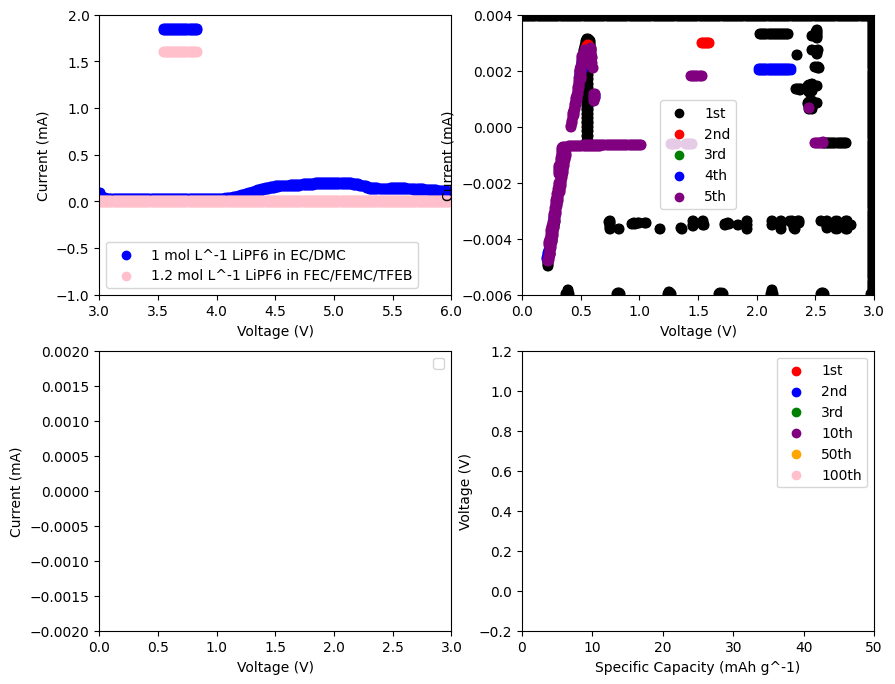

In [19]:
# VISUALIZE A BUNCH AT ONCE

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

figures = [(0,0), (0,1), (1,0), (1,1)]

for image_num in range(1, 5):
    fig_i = image_num - 1
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num)
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, False)

    ax = axs[figures[fig_i][0], figures[fig_i][1]]

    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])
        
        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): ax.scatter(x, y, label=axis_labels[index], color=color_normalized)

    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])

    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)
    ax.legend()

IMAGE NUMBER 1
(418, 352)
(418, 352)


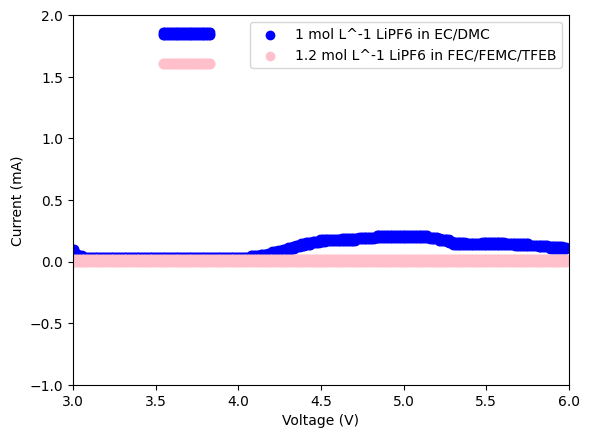

(418, 352)
(418, 352)


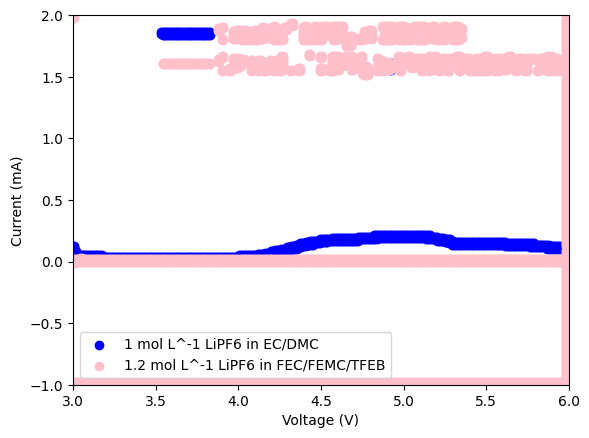

IMAGE NUMBER 2
(428, 334)
(428, 334)
(428, 334)
(428, 334)
(428, 334)


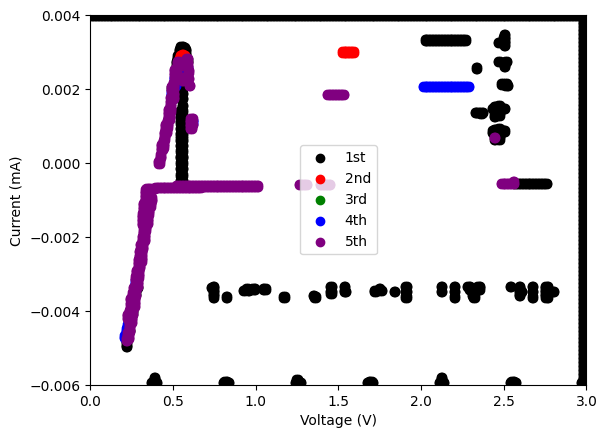

(428, 334)
(428, 334)
(428, 334)
(428, 334)
(428, 334)


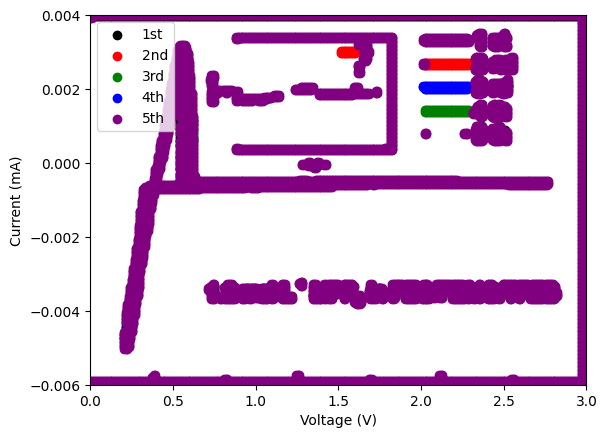

IMAGE NUMBER 3
(432, 326)
(432, 326)
(432, 326)
(432, 326)
(432, 326)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


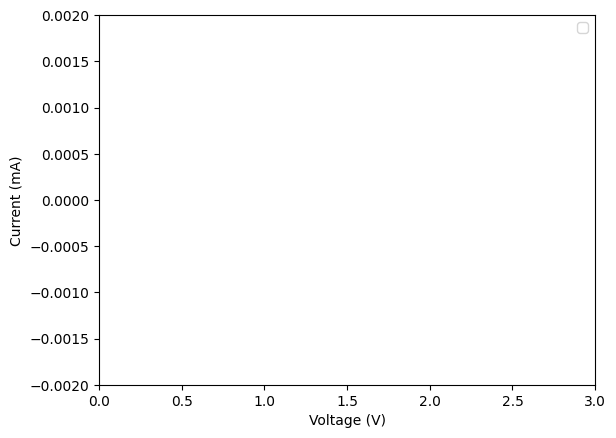

(432, 326)
(432, 326)
(432, 326)
(432, 326)
(432, 326)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


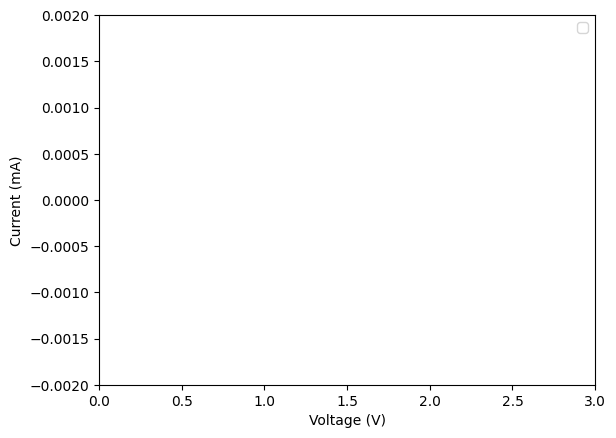

IMAGE NUMBER 4
(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)


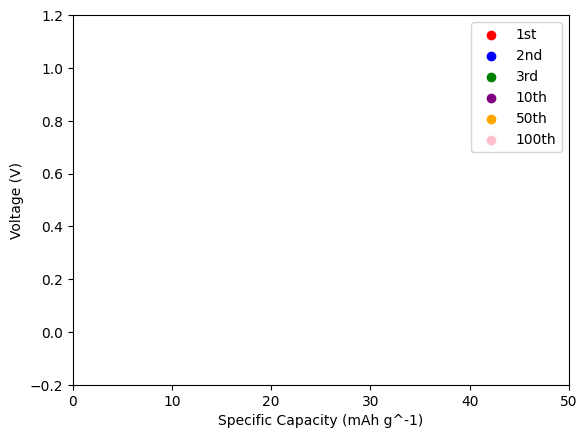

(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)
(430, 326)


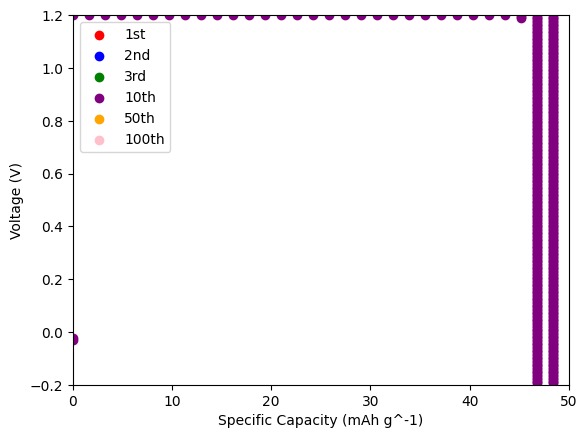

IMAGE NUMBER 5
(434, 316)
(434, 316)


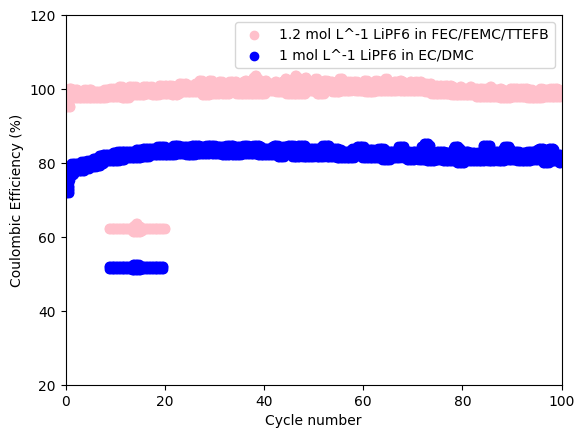

(434, 316)
(434, 316)


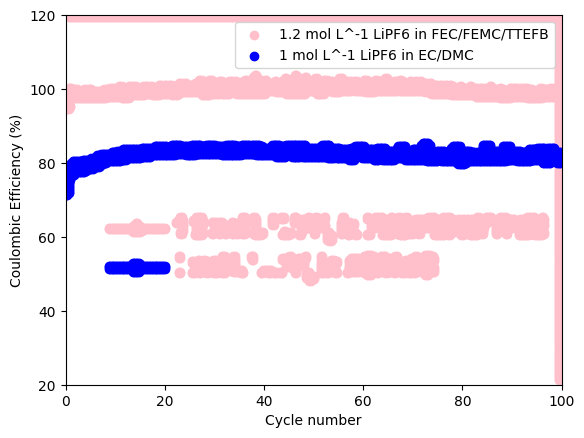

IMAGE NUMBER 6
(422, 316)
(422, 316)
(422, 316)
(422, 316)
(422, 316)


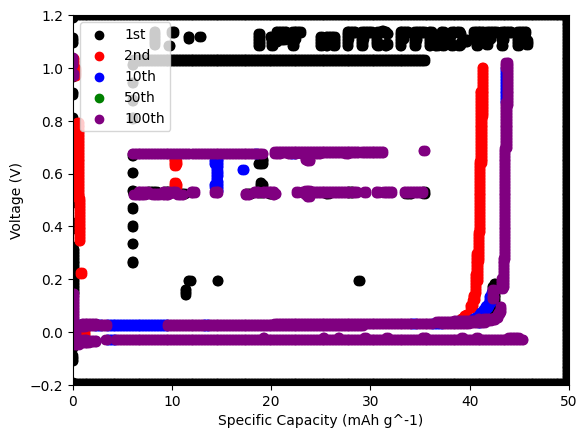

(422, 316)
(422, 316)
(422, 316)
(422, 316)
(422, 316)


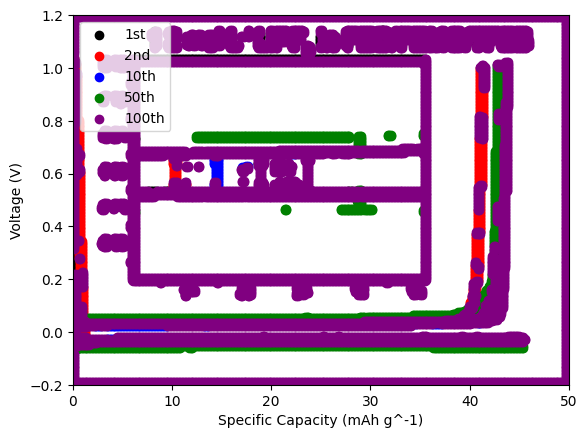

IMAGE NUMBER 7
(818, 398)
(818, 398)
(818, 398)


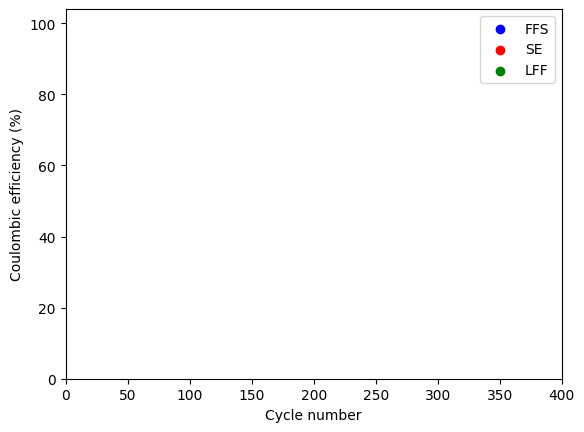

(818, 398)
(818, 398)
(818, 398)


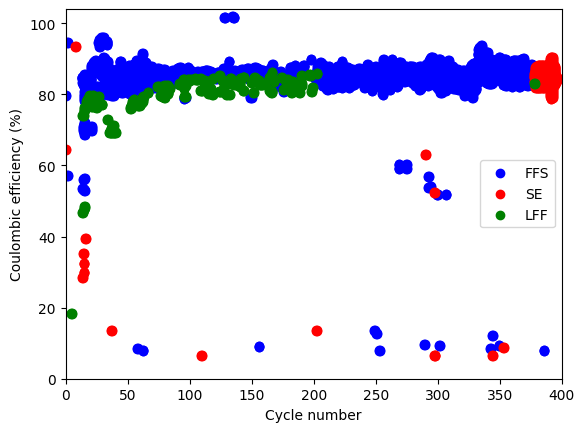

IMAGE NUMBER 8
(500, 346)
(500, 346)


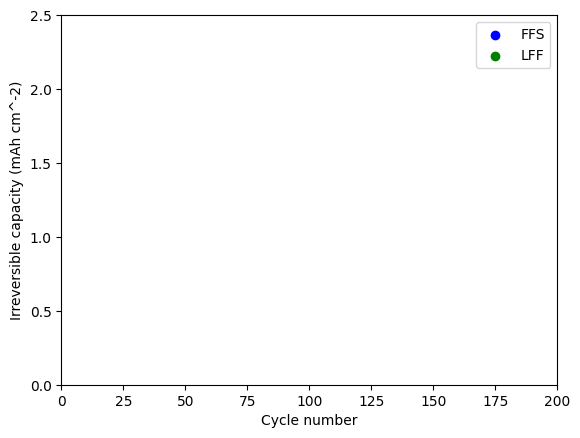

(500, 346)
(500, 346)


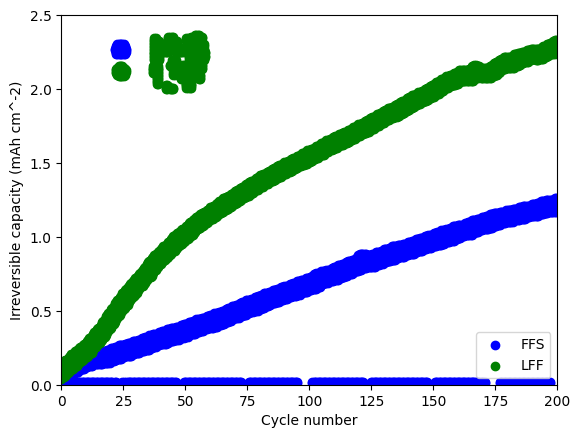

IMAGE NUMBER 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


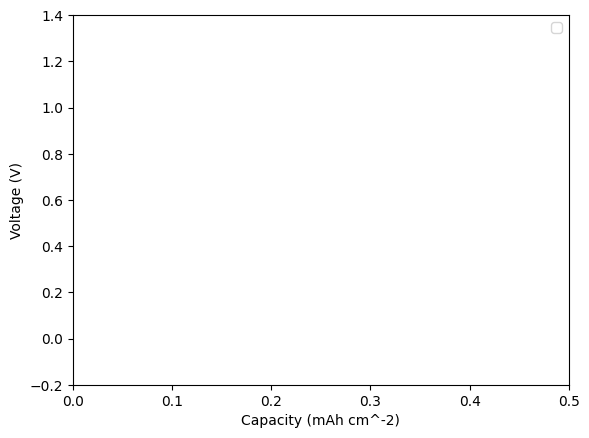

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


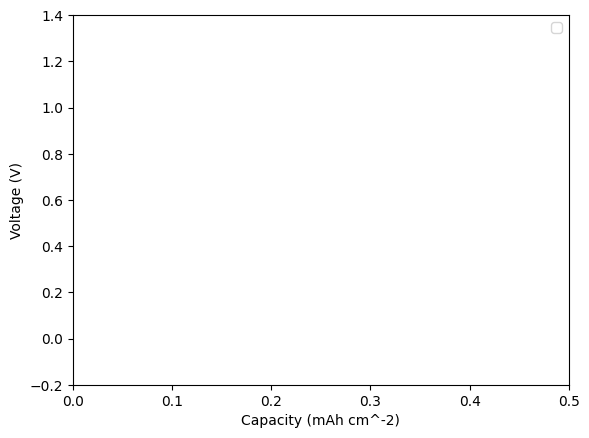

IMAGE NUMBER 10
(496, 378)
(496, 378)


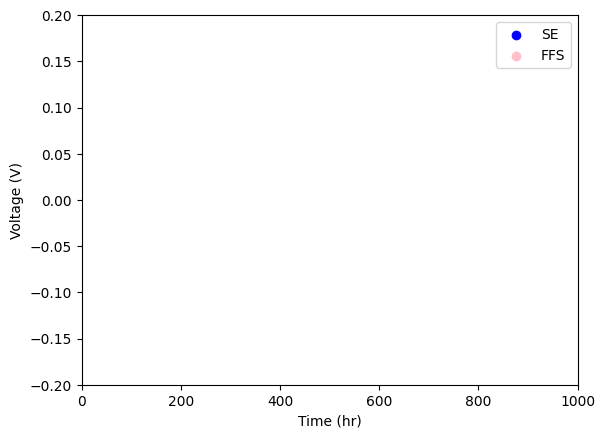

(496, 378)
(496, 378)


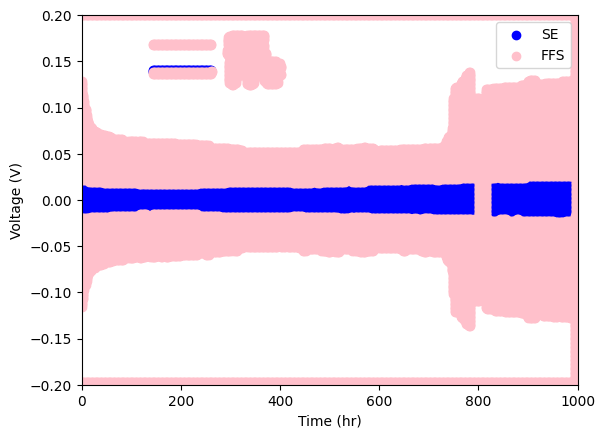

IMAGE NUMBER 11
(376, 190)
(376, 190)


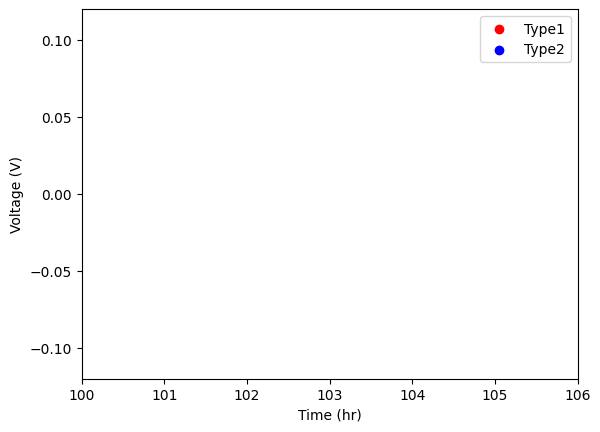

(376, 190)
(376, 190)


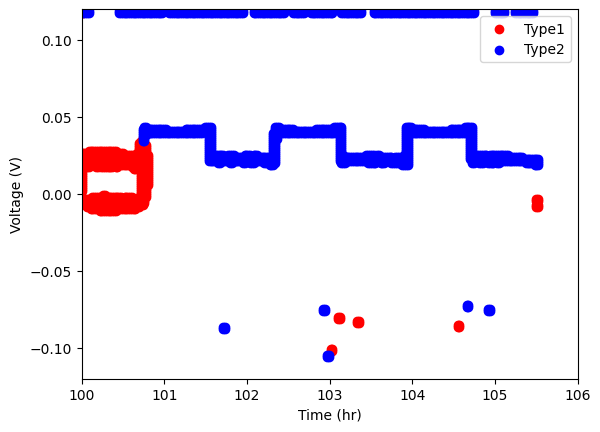

IMAGE NUMBER 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


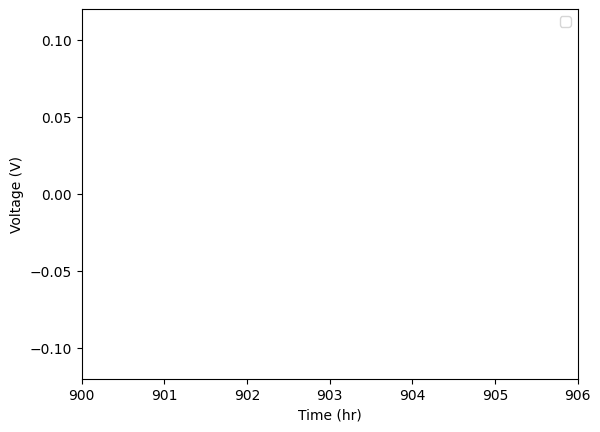

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


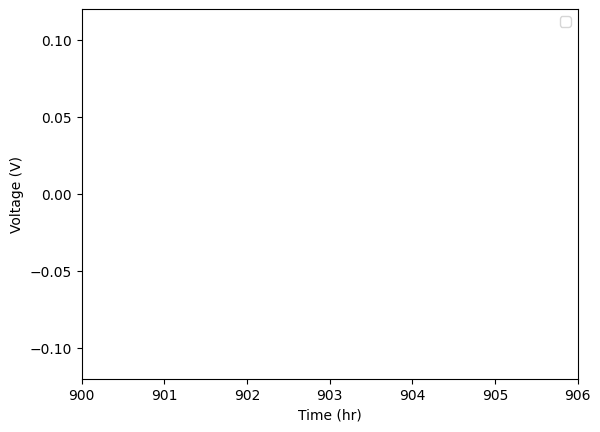

IMAGE NUMBER 13
(644, 324)
(644, 324)
(644, 324)


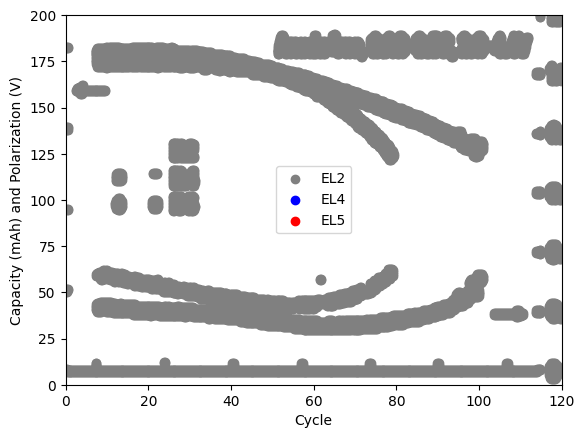

(644, 324)
(644, 324)
(644, 324)


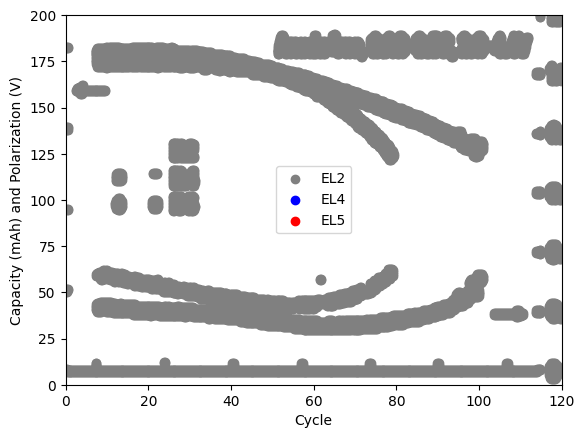

IMAGE NUMBER 14
(334, 326)
(334, 326)
(334, 326)


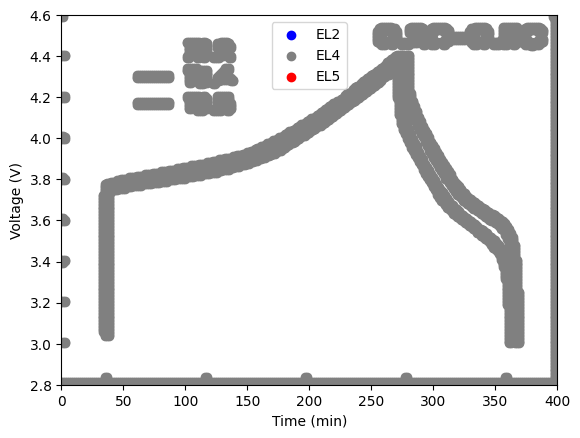

(334, 326)
(334, 326)
(334, 326)


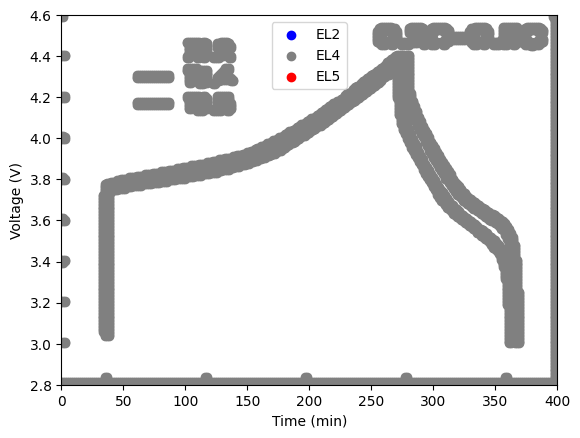

IMAGE NUMBER 15
(628, 322)
(628, 322)
(628, 322)


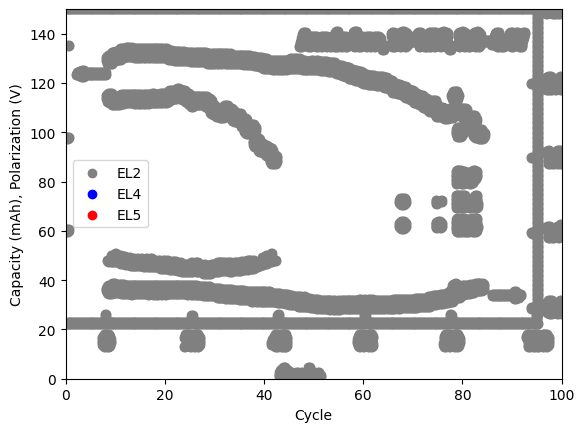

(628, 322)
(628, 322)
(628, 322)


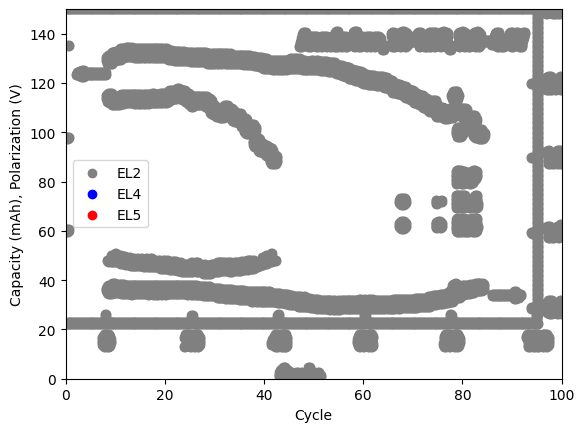

IMAGE NUMBER 16
(654, 342)
(654, 342)
(654, 342)


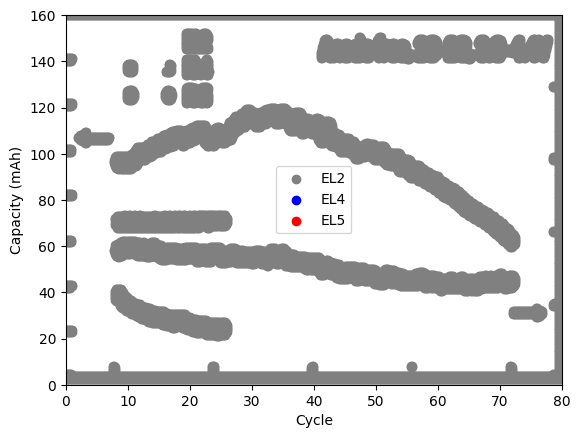

(654, 342)
(654, 342)
(654, 342)


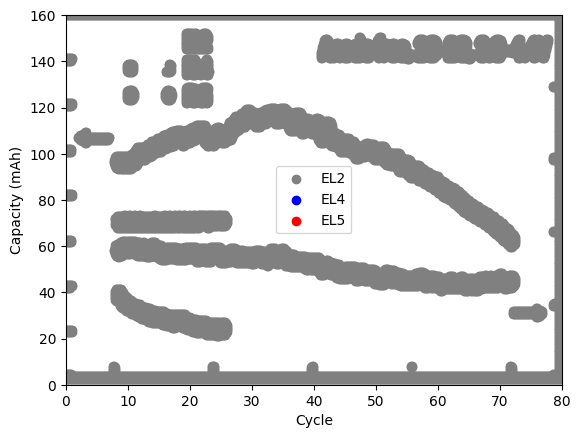

IMAGE NUMBER 17
(372, 342)
(372, 342)
(372, 342)


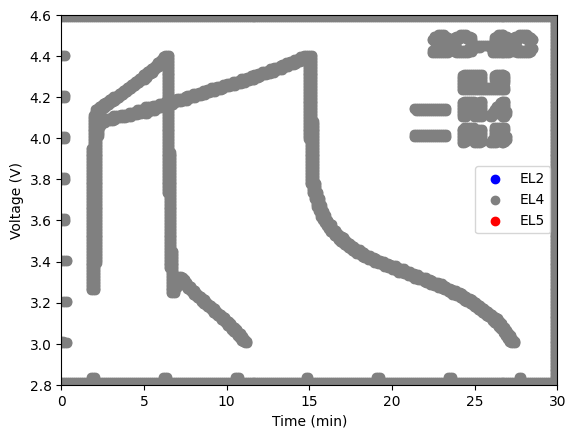

(372, 342)
(372, 342)
(372, 342)


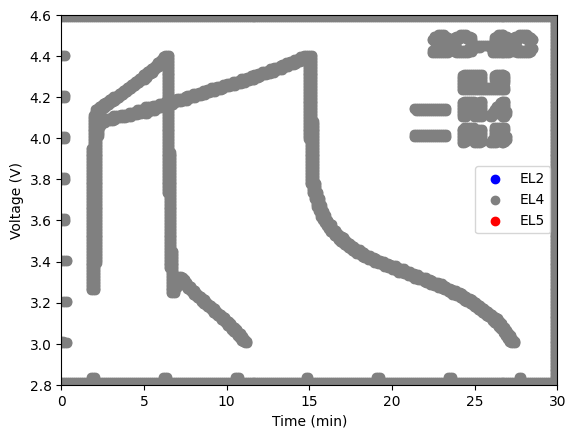

IMAGE NUMBER 18
(342, 328)
(342, 328)
(342, 328)


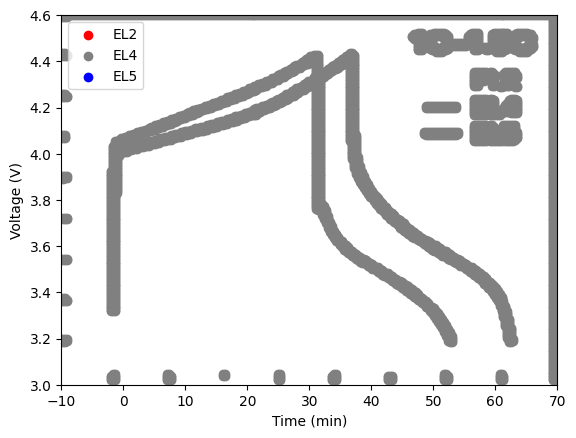

(342, 328)
(342, 328)
(342, 328)


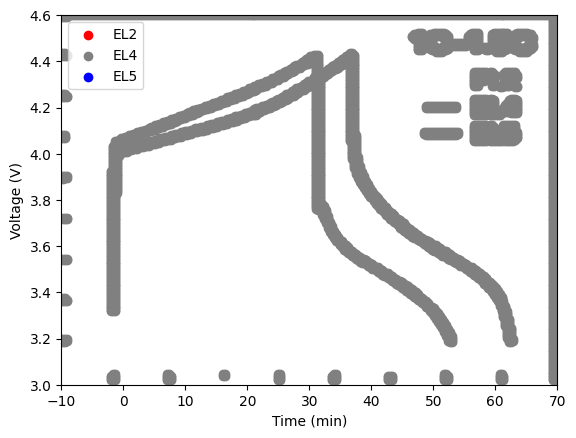

IMAGE NUMBER 19
(458, 378)
(458, 378)


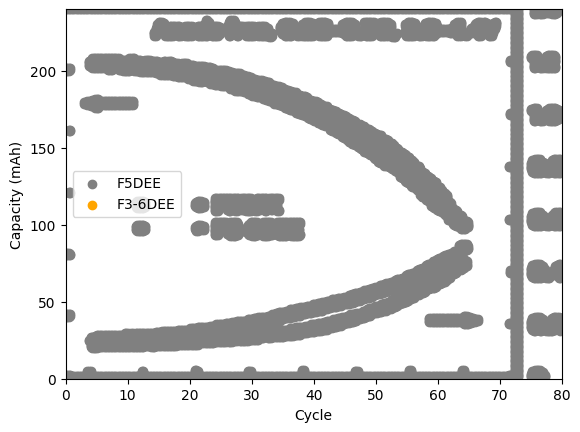

(458, 378)
(458, 378)


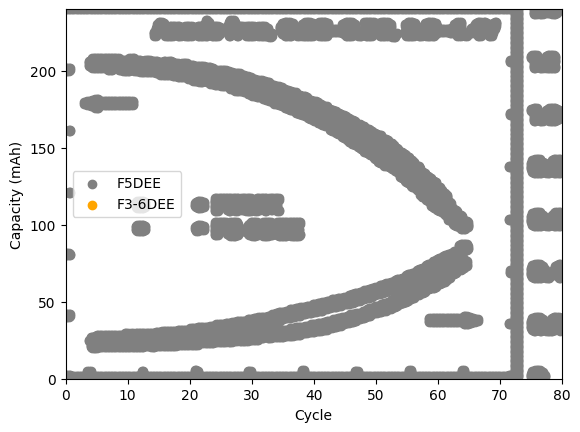

IMAGE NUMBER 20
(444, 384)
(444, 384)


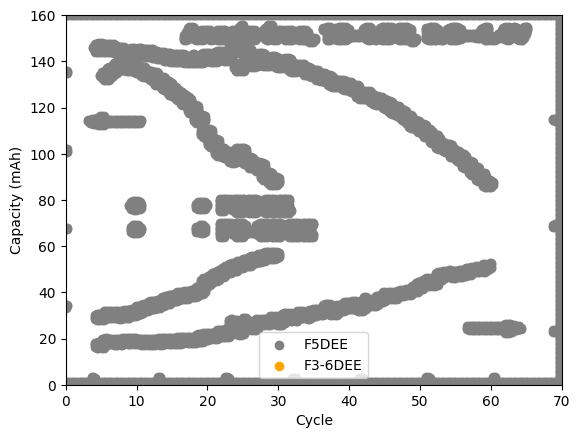

(444, 384)
(444, 384)


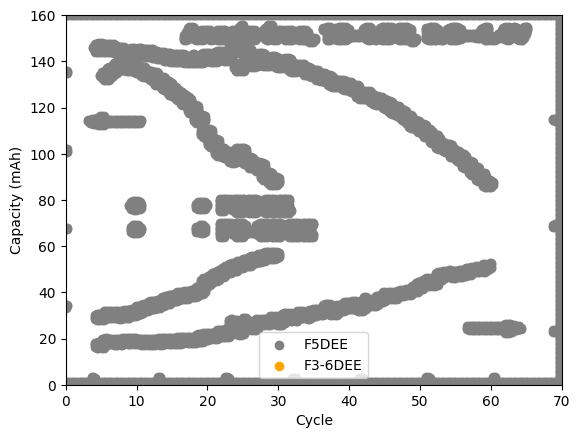

IMAGE NUMBER 21
(456, 382)
(456, 382)


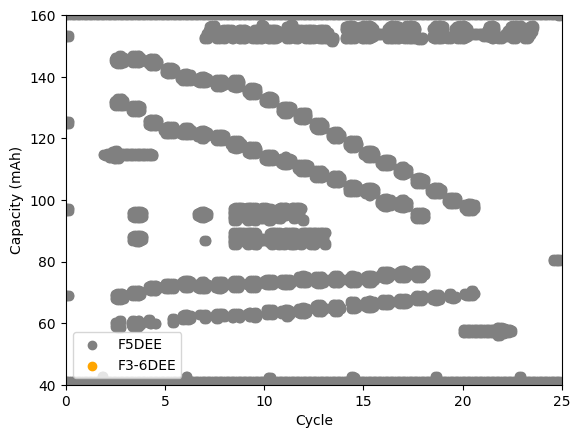

(456, 382)
(456, 382)


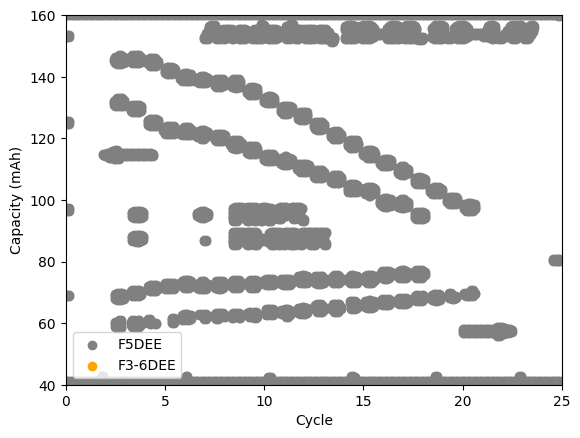

IMAGE NUMBER 22
(1262, 1016)
(1262, 1016)
(1262, 1016)


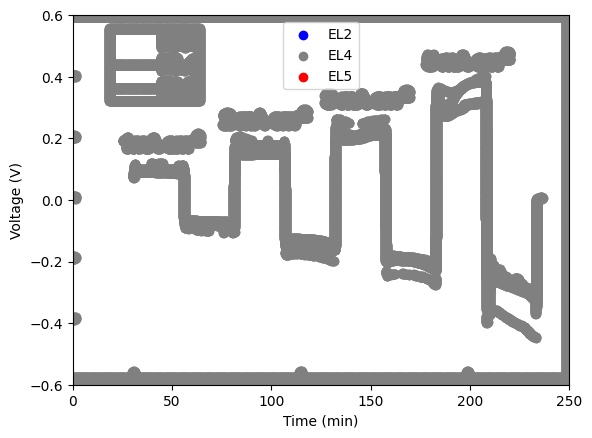

(1262, 1016)
(1262, 1016)
(1262, 1016)


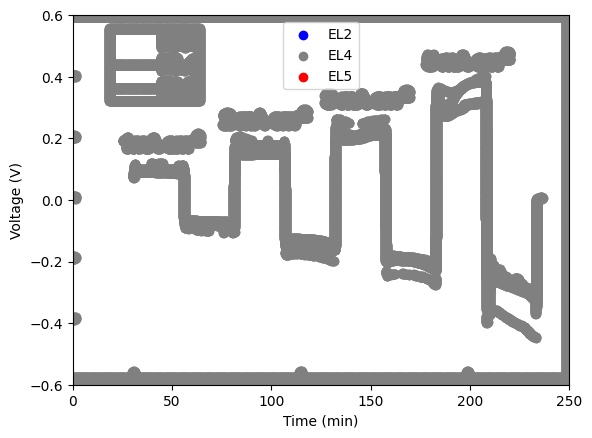

IMAGE NUMBER 23
(1074, 854)
(1074, 854)
(1074, 854)


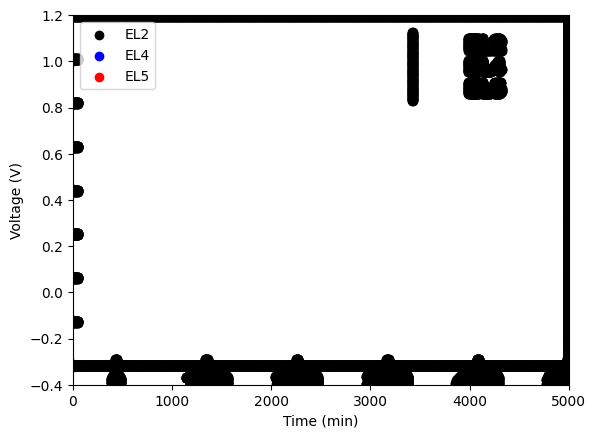

(1074, 854)
(1074, 854)
(1074, 854)


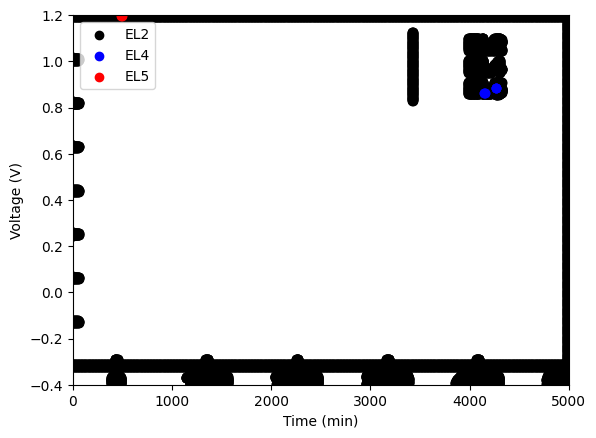

IMAGE NUMBER 24
(1070, 846)
(1070, 846)
(1070, 846)


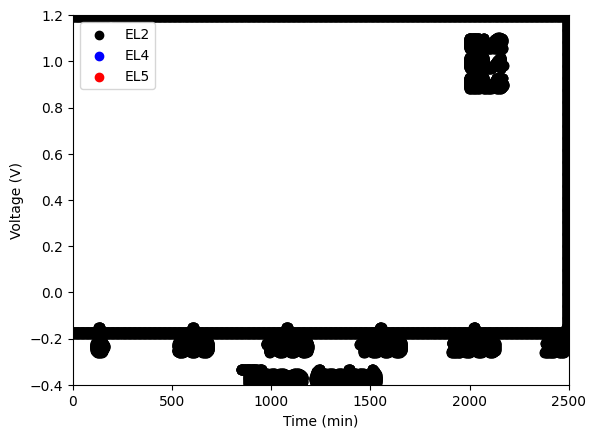

(1070, 846)
(1070, 846)
(1070, 846)


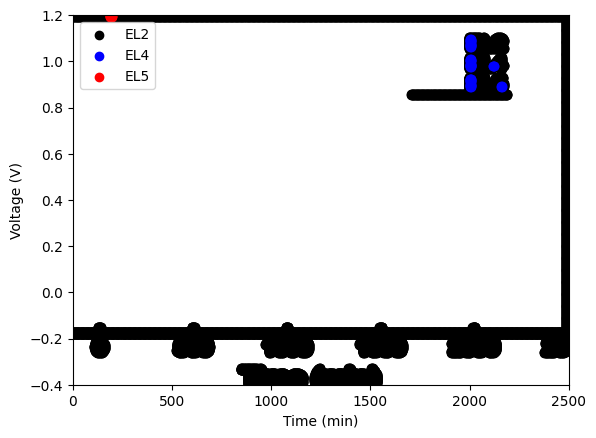

IMAGE NUMBER 25
(1390, 676)
(1390, 676)
(1390, 676)


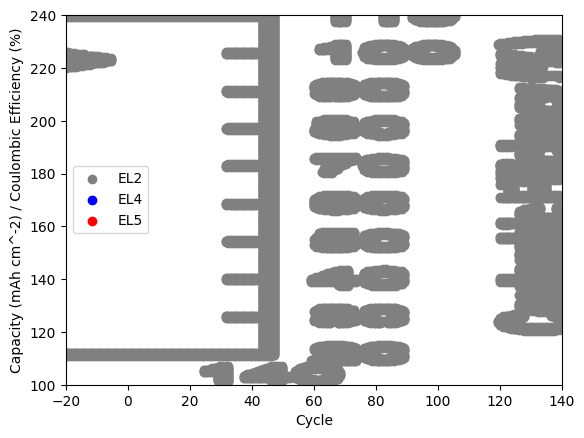

(1390, 676)
(1390, 676)
(1390, 676)


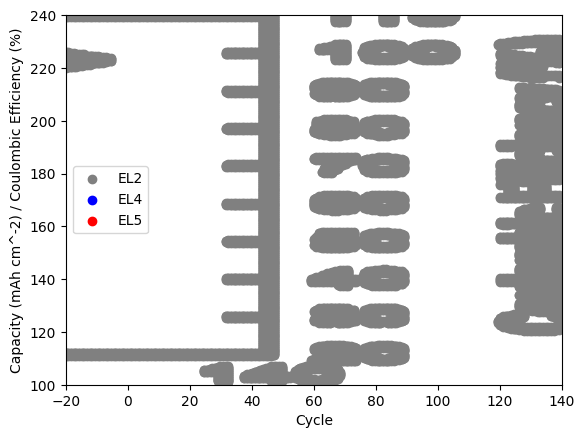

IMAGE NUMBER 26
(1384, 712)
(1384, 712)
(1384, 712)


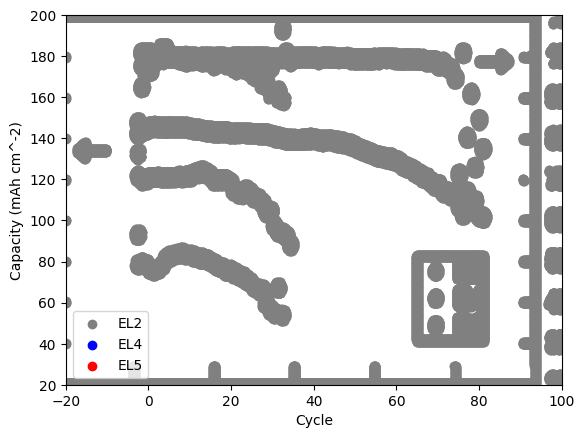

(1384, 712)
(1384, 712)
(1384, 712)


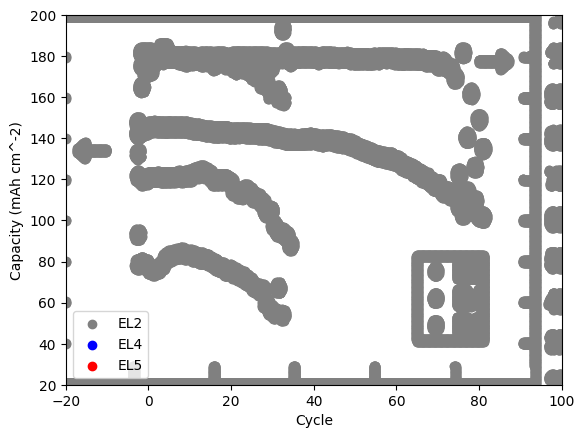

IMAGE NUMBER 27
(1396, 734)
(1396, 734)
(1396, 734)


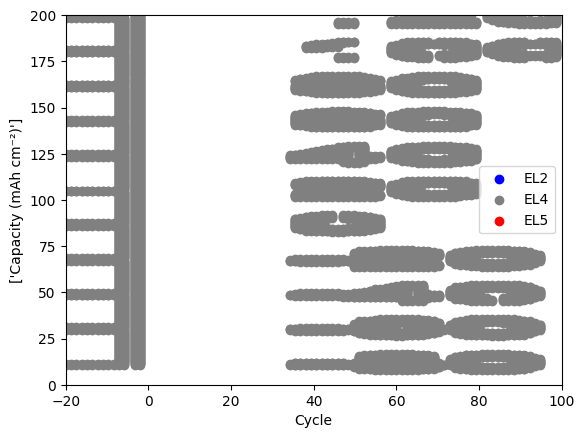

(1396, 734)
(1396, 734)
(1396, 734)


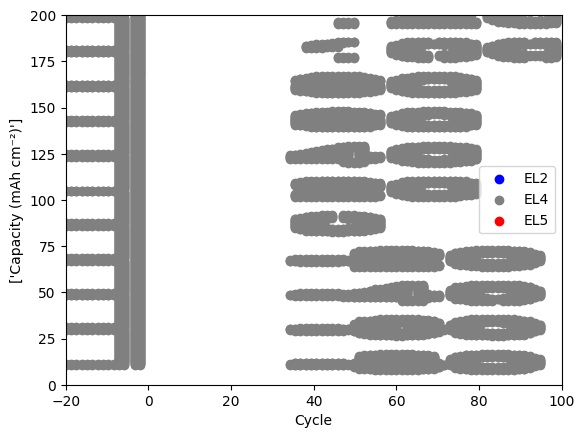

IMAGE NUMBER 28
(886, 362)
(886, 362)


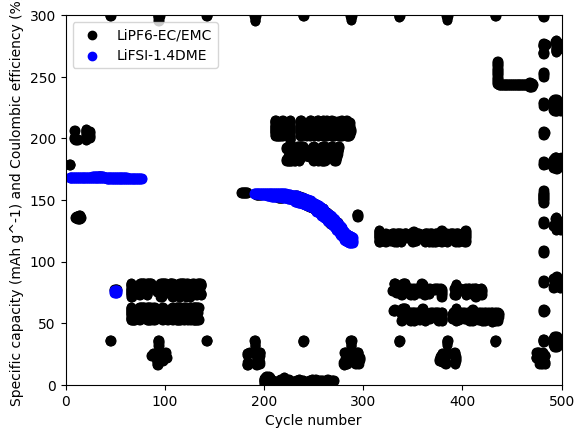

(886, 362)
(886, 362)


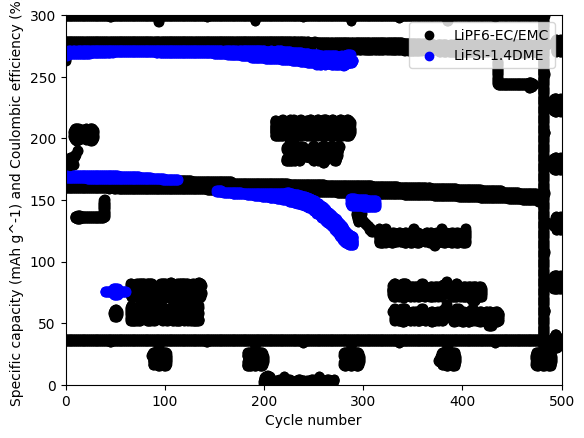

In [20]:
for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num)

    # NUMBER 1
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, False)
    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()

    # NUMBER 2
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, True)
    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])

    # Add title and labels
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()
